This Notebook aims to present some of the main matter density profiles of dark matter halos, for that we will use the Numerical Cosmology [(NumCosmo)](https://numcosmo.github.io/) and [Colossus](https://bdiemer.bitbucket.io/colossus/index.html#) libraries. 

The study of dark matter halos is of particular interest to cosmologists because it is in these halos that baryonic matter agglomerates, cools and condenses, forming structures such as galaxies and clusters of galaxies. But how is dark matter distributed in these objects? This question could be answered with the density halo profiles.

For years, researchers tried to find a density profile that was universal, so numerous N-body simulations were performed arriving at different models that mostly tend to behave well in the innermost region of the halo.

**NFW Profile**

In a series of articles published in the 1990s, Julio Navarro, Carlos Frenk and Simon WHite, perfoming N-body simulation of high resolution found out that all virialized dark matter halo density profile have the same shape regardless of halo mass, spectrum of initial density fluctuations and values of cosmological parameters.The NFW profile is describe as follows,

\begin{equation}
\rho_{NFW}(r) = \frac{\rho_s}{\Big(\frac{r}{r_s}\Big)\Big(1 + \frac{r}{r_s}\Big)^2},
\end{equation}

where $r_s$ and $\rho_s$ are the characteristic radius and density, respectively.

**Hernquist Profile**

The Hernquist profile is a proposed model to describe the distribution of matter in elliptical galaxies. The Hernquist model can be used for theoretical and observational predictions, being analytical, the kinematic properties of this model can be used to infer dynamic aspects of galaxies directly from observations. This profile is given as follows

\begin{equation}
\rho_{HER}(r) = \frac{\rho_s}{\Big(\frac{r}{r_s}\Big)\Big(1+\frac{r}{r_s}\Big)^3},
\end{equation}

where $\rho_s$ is the characteristic density given by

\begin{equation}
\rho_s = \frac{2}{3}\rho_\Delta  c_\Delta(1+c_\Delta)^2,
\end{equation}

where c is the concentration parameter, $c_\Delta = r_\Delta/r_s$ and $\rho_\Delta$ is the density of a spherical overdensity $\Delta(z)$.

**Einasto Profile**

Recently, N-body simulations have shown that three-parameter profiles provide an excellent fit to a wide range of dark matter halos. One of these is the Einasto profile (1965) which has the same mathematical form as Sersic's law that is used to describe the surface brightness profile (ie, projected density) of galaxies. The Einasto Profile is describe as follows,

\begin{equation}
\rho_{EIN}(r) = \rho_s\exp\bigg\{\frac{-2}{\alpha}\Big[\Big(\frac{r}{r_s}\Big)^{\alpha} - 1\Big]\bigg\}
\end{equation}

where $\alpha$ is an additional parameter.

Now let's go code! We start by importing the libraries needed for our analysis.

In [1]:
try:
    import gi
    gi.require_version('NumCosmo', '1.0')
    gi.require_version('NumCosmoMath', '1.0')
except:
    pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_hernquist
from colossus.halo import mass_so
from colossus.utils import constants

import sys
from scipy.misc import derivative
import matplotlib
import matplotlib.pyplot as plt
#plt.style.use('classic')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 12
%matplotlib inline
import numpy as np
import math

In [2]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
params = cosmology.cosmologies['planck18']
params['de_model'] = 'w0wa'
params['w0'] = -0.8
params['wa'] = 0.1
#params['interpolation'] = False
params['persistence'] = ''

cosmo_col = cosmology.setCosmology('planck_w0wa', params)
#cosmo_col = cosmology.setCosmology('planck18');

#cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<0>}")
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        cosmo_col.H0)
cosmo.param_set_by_name ("Omegak",    cosmo_col.Ok(0.0))
cosmo.param_set_by_name ("w0",        cosmo_col.w0)
cosmo.param_set_by_name ("w1",        cosmo_col.wa)
cosmo.param_set_by_name ("Omegab",    cosmo_col.Ob0)
cosmo.param_set_by_name ("Omegac",    (cosmo_col.Om0 - cosmo_col.Ob0))
#cosmo.param_set_by_name ("massnu_0",  Planck13.m_nu.value[2])
cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff - 3.0*cosmo.E2Press_mnu(1.0e10) / (cosmo.E2Omega_g(1.0e10) * (7/8*(4/11)**(4/3))))
cosmo.param_set_by_name ("Tgamma0",   cosmo_col.Tcmb0)

In this tutorial we will use the correlation function to construct the density term of 2 halos, but first we need to define our power spectrum for this we will use the [NcPowspecMLTransfer](https://numcosmo.github.io/manual/NcPowspecMLTransfer.html), a class that gives a power spectrum of linear matter as a function of the 𝑘-mode and redshift 𝑧 using a transfer function.

In [4]:
reion  = Nc.HIReionCamb.new ()
prim   = Nc.HIPrimPowerLaw.new ()

cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

tf_eh = Nc.TransferFuncEH.new ()
ps_eh  = Nc.PowspecMLTransfer.new (tf_eh)

# Redshift bounds
z_min = 0.0
z_max = 2.0
zdiv  = 0.49999999999

# Mode bounds
k_min = 1.0e-5
k_max = 1.0e3

nk = 2000

ps_eh.set_kmin (k_min)
ps_eh.set_kmax (k_max)
ps_eh.require_zi (z_min)
ps_eh.require_zf (z_max)

prim.param_set_by_name ("n_SA", cosmo_col.ns)
reion.param_set_by_name ("z_re", 9.9999)

# Prepares the power spectrum using the cosmological model.
ps_eh.prepare (cosmo)

old_logAs = prim.param_get_by_name ("ln10e10ASA") 
a         = 2.0 * math.log (cosmo_col.sigma8 / ps_eh.sigma_tophat_R (cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h ()))
new_logAs = old_logAs + a

prim.param_set_by_name ("ln10e10ASA", new_logAs)

cosmo_col = cosmology.getCurrent()


In [5]:
def cmp_double (desc, m1, m2, x1, x2):
    print ("%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e" % (desc, m1, x1, m2, x2, math.fabs (x1 / x2 - 1.0)))

Modules [Dark matter halos](https://bdiemer.bitbucket.io/colossus/halo.html) and [NcHaloDensityProfile](https://numcosmo.github.io/manual/NcHaloDensityProfile.html) will be the stars of this part of the code. They contain the main functions presented in the introduction of this notebook, with the characteristic radius and density, in addition to the density profiles for each model.

In [6]:
Delta = 200.0
Mvir  = 1.0e15 # M_sun
cvir  = 5.0
z     = 0.0

# Colossus
col_nfw = profile_nfw.NFWProfile (M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir')
col_ein = profile_einasto.EinastoProfile (M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir')
col_her = profile_hernquist.HernquistProfile (M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir')

alpha = col_ein.par['alpha']

In [7]:
# NumCosmo
reltol = 1.0e-9
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True

nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.VIRIAL, Delta) 
nc_nfw.param_set_by_name ('cDelta', cvir) 
nc_nfw.param_set_by_name ('log10MDelta', np.log10(Mvir)) 

if improve_prec:
    nc_nfw.set_reltol (reltol) 
    nc_nfw.set_lnXi (lnXi)
    nc_nfw.set_lnXf (lnXf)

nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.VIRIAL, Delta)
nc_ein.param_set_by_name ('cDelta', cvir) 
nc_ein.param_set_by_name ('log10MDelta', np.log10(Mvir))
nc_ein.param_set_by_name ('alpha', alpha)

if improve_prec:
    nc_ein.set_reltol (reltol) 
    nc_ein.set_lnXi (lnXi)
    nc_ein.set_lnXf (lnXf)

nc_her = Nc.HaloDensityProfileHernquist.new (Nc.HaloDensityProfileMassDef.VIRIAL, Delta)
nc_her.param_set_by_name ('cDelta', cvir) 
nc_her.param_set_by_name ('log10MDelta', np.log10(Mvir))

if improve_prec:
    nc_her.set_reltol (reltol) 
    nc_her.set_lnXi (lnXi)
    nc_her.set_lnXf (lnXf)

smd = Nc.WLSurfaceMassDensity.new (Nc.Distance.new (5.0))
smd.prepare (cosmo)

**Comparing NFW, Einasto and Hernquist the scale radius $r_s$ and $\rho_s$**

In [8]:
r = 10**np.arange(0,5,0.02)* 1.0e-3 
rho_m = cosmo_col.rho_m (z) * (cosmo.h2 () * 1.0e9) # matter density units: M_sun / Mpc^3

# Colossus 
(col_rhos, col_rs)  = col_nfw.fundamentalParameters (Mvir * cosmo.h (), cvir, z, 'vir')

# NumCosmo
(nc_nfw_rs, nc_nfw_rhos)    = nc_nfw.r_s_rho_s (cosmo, z)

cmp_double ("NFW:rhos", "Colossus", "NumCosmo", col_rhos * (cosmo.h2 () * 1.0e9), nc_nfw_rhos)
cmp_double ("NFW:rs  ", "Colossus", "NumCosmo", col_rs / 1.0e3 / cosmo.h (), nc_nfw_rs)

col_ein.fundamentalParameters (Mvir * cosmo.h (), cvir, z, 'vir', alpha = alpha)
(col_rhos, col_rs) = (col_ein.par['rhos'], col_ein.par['rs'])
(nc_ein_rs, nc_ein_rhos)   = nc_ein.r_s_rho_s (cosmo, z)

cmp_double ("EIN:rhos", "Colossus", "NumCosmo", col_rhos * (cosmo.h2 () * 1.0e9), nc_ein_rhos)
cmp_double ("EIN:rs  ", "Colossus", "NumCosmo", col_rs / (cosmo.h () * 1.0e3), nc_ein_rs)

(col_rhos, col_rs) = col_her.fundamentalParameters (Mvir * cosmo.h (), cvir, z, 'vir')
(nc_her_rs, nc_her_rhos)   = nc_her.r_s_rho_s (cosmo, z)

cmp_double ("HER:rhos", "Colossus", "NumCosmo", col_rhos * (cosmo.h2 () * 1.0e9), nc_her_rhos)
cmp_double ("HER:rs  ", "Colossus", "NumCosmo", col_rs / (cosmo.h () * 1.0e3), nc_her_rs)


NFW:rhos: Colossus =        567011272558649, NumCosmo =        567011272558899, CMP:  4.41e-13
NFW:rs  : Colossus =      0.527084119496637, NumCosmo =       0.52708411949656, CMP:  1.47e-13
EIN:rhos: Colossus =        143943283513167, NumCosmo =        143943283513230, CMP:  4.41e-13
EIN:rs  : Colossus =      0.527084119496637, NumCosmo =       0.52708411949656, CMP:  1.47e-13
HER:rhos: Colossus =   1.56510265814535e+15, NumCosmo =   1.56510265814604e+15, CMP:  4.41e-13
HER:rs  : Colossus =      0.527084119496637, NumCosmo =       0.52708411949656, CMP:  1.47e-13


**Comparing NFW, Einasto and Hernquist inner profiles $\rho(r) /\rho_m$**

In [9]:
# Colossus density profiles
col_rho_nfw = col_nfw.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)
col_rho_ein = col_ein.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)
col_rho_her = col_her.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

# NumCosmo density profiles
nc_rho_nfw  = np.array (nc_nfw.eval_density_array (cosmo, r, 1.0, 1.0, z))
nc_rho_ein  = np.array (nc_ein.eval_density_array (cosmo, r, 1.0, 1.0, z))
nc_rho_her  = np.array (nc_her.eval_density_array (cosmo, r, 1.0, 1.0, z))

In [10]:
Rvir_nfw = col_nfw.RDelta(z, 'vir')/ (cosmo.h () * 1.0e3)
rs = col_nfw.par['rs']/ (cosmo.h () * 1.0e3)

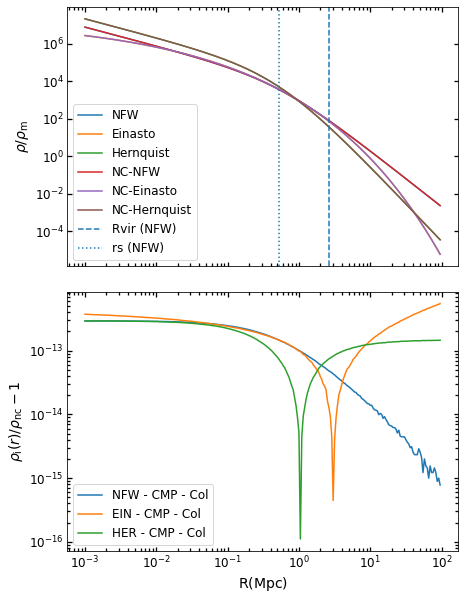

In [11]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xlabel(r'${\mathrm{R(Mpc)}}$')
axs[0].set_ylabel(r'$\rho / \rho_{\mathrm{m}}$')
axs[0].plot(r, col_rho_nfw / rho_m, '-', lw = 1.5, label = 'NFW');
axs[0].plot(r, col_rho_ein / rho_m, '-', lw = 1.5, label = 'Einasto');
axs[0].plot(r, col_rho_her / rho_m, '-', lw = 1.5, label = 'Hernquist');

axs[0].plot(r, nc_rho_nfw / rho_m, '-', lw = 1.5, label = 'NC-NFW');
axs[0].plot(r, nc_rho_ein / rho_m, '-', lw = 1.5, label = 'NC-Einasto');
axs[0].plot(r, nc_rho_her / rho_m, '-', lw = 1.5, label = 'NC-Hernquist');
axs[0].axvline(Rvir_nfw, ls = '--', label = 'Rvir (NFW)');
axs[0].axvline(rs, ls = ':', label = 'rs (NFW)');
axs[0].legend(loc='best')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\rho_{\mathrm{i}}(r) / \rho_{\mathrm{nc}} - 1$')
axs[1].plot(r, np.abs(col_rho_nfw/nc_rho_nfw - 1.), '-', lw = 1.5, label = "NFW - CMP - Col");
axs[1].plot(r, np.abs(col_rho_ein/nc_rho_ein - 1.), '-', lw = 1.5, label = "EIN - CMP - Col");
axs[1].plot(r, np.abs(col_rho_her/nc_rho_her - 1.), '-', lw = 1.5, label = "HER - CMP - Col");
axs[1].legend(loc='best');
axs[1].tick_params(which='major',direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor',direction='in', right=True, top=True, length=3.0, width=1.3)

plt.savefig ("rho_profiles.pdf", dpi=300, bbox_inches='tight')

### Outer Profiles

The main models for the external density profile are the average matter density term, the 2-halo density term, and the power law terms, given by [OuterTermMeanDensity](https://bdiemer.bitbucket.io/colossus/halo_profile_outer.html#halo.profile_outer.OuterTermMeanDensity), [OuterTermCorrelationFunction](https://bdiemer.bitbucket.io/colossus/halo_profile_outer.html#halo.profile_outer.OuterTermCorrelationFunction), and [OuterTermPowerLaw](https://bdiemer.bitbucket.io/colossus/halo_profile_outer.html#halo.profile_outer.OuterTermPowerLaw) in the Colossus library, respectively. Unfortunately NumCosmo does not yet have these functions implemented in its library, but here we are going to make some adaptations with functions already present in Nc to calculate the average density and 2-halo term. To further enrich our discussion of density profiles we will also include the calculation of the derivatives and logarithmic derivatives of the profiles, which are also not available in NumCosmo.

In [12]:
# Defining the two-point or matter-matter correlation function
def xi_mm(r, z):
    psc_3d = Ncm.PowspecCorr3d.new(ps_eh)
    psc_3d.prepare(cosmo)

    r_c = (r * (1 + z))
    R_min = (cosmo_col.R_xi[0] * 1.00001)
    R_max = (cosmo_col.R_xi[-1] * 0.99999)

    xi = []

    for r_i in r_c:
        mask_not_small = (r_i > R_min)
        mask_not_large = (r_i < R_max)
        mask_small = (r_i < R_min)
        mask_large = (r_i > R_max)
        mask = (mask_not_small & mask_not_large)
        if (mask):
            xi_matter = psc_3d.eval_xi(z, r_i)#(r_i, z)
            xi.append(xi_matter)
        if (mask_small):
            xi_matter = psc_3d.eval_xi(z, R_min)#(R_min, z)
            xi.append(xi_matter)
        if (mask_large):
            xi_matter = psc_3d.eval_xi(z, R_max)#(R_max, z)
            xi.append(xi_matter)
    return np.array(xi)

In [13]:
# Defining the two halo term and its derivative
def TwoHalo(r, z, bias):
    rho_2h = rho_m*bias*xi_mm(r, z)
    return rho_2h
    
def dTwoHalo(r, z, bias):    
    function = lambda x: TwoHalo(x, z, bias)
    drho_2h = derivative(function, r, dx=1e-6)  
    
    return drho_2h

def Mean(z):
    rho_crit_nc = Ncm.C.crit_mass_density_h2_solar_mass_Mpc3 ()*cosmo.h2()
    rho_m_nc = (cosmo.E2Omega_m (z)*rho_crit_nc)
    return np.ones(len(r),float)*rho_m_nc

def dMean(r):
	return np.zeros(len(r),float)

It is important to note that if we are considering the external profile in the implementation, then the total profile will actually be given by

\begin{equation}
\rho_{TOT}(r) = \rho_{IN}(r) + \rho_{OUT}(r)
\end{equation}

and consequently its logarithmic derivative will be

\begin{equation}
\frac{d\mathrm{ln}(\rho_{TOT})}{d\mathrm{ln}(r)} = \frac{r}{\rho_{TOT}}\Big[\frac{d\rho_{IN}}{dr} + \frac{d\rho_{OUT}}{dr}\Big].
\end{equation}

In [14]:
# Defining the total profile and its derivative
def rhoTotal(rhoInner, rhoOuter):
    return rhoInner + rhoOuter

def dlogTotal(rhoTotal, dInner, dOuter):
    return (r/rhoTotal)*(dInner + dOuter)

##### Derivative of the internal profiles

In [15]:
# Hernquist density profile linear derivative
def dHER(r_s, rho_her):
    x = r/r_s
    return -rho_her*((1.0/r_s)*(1.0+x)+3.0*x/r_s)/(x*(1.0+x))

# Hernquist density profile logarithmic derivative
def dlogHER(r_s):
    x=r/r_s
    return -(1.0+3.0*x/(1.0+x))

# NFW density profile linear derivative
def dNFW(r_s, rho_nfw):
    x = r/r_s
    return -rho_nfw*((1.0/r_s)*(1.0+x)+2.0*x/r_s)/(x*(1+x))

# NFW density profile logarithmic derivative
def dlogNFW(r_s):
    x = r/r_s
    return -(1.0+2.0*x/(1.0+x))

# Einasto density profile linear derivative
def dEIN (r_s, rho_ein):
    return -2.0*rho_ein*(r/r_s)**alpha/r

#(inner) Einasto density profile logarithmic derivative
def dlogEIN(r_s):
    return -2.0*(r/r_s)**alpha

In [16]:
# First I will test the Outer Profilees function from Colossus, later I will try to do tha same think using 
# NuCosmo functions

from colossus.halo import profile_outer
from colossus.lss import bias

mdef = 'vir'
z = 0.0
sigma = 4.0
nu = 1.686/sigma
b = bias.haloBiasFromNu(nu, z, mdef, model = "sheth01")

outer_term_mean = profile_outer.OuterTermMeanDensity(z = z)
outer_term_cf = profile_outer.OuterTermCorrelationFunction(z=z, bias=b)

# NFW
### Mean ###
outer_NFW = profile_nfw.NFWProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_mean])
rho_outer_NFW = outer_NFW.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

### 2-Halo ###
outer_cf_NFW = profile_nfw.NFWProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_cf])
rho_cf_NFW = outer_cf_NFW.density(r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

### 2-Halo + Mean ###
mean_cf_NFW = profile_nfw.NFWProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_cf]+[outer_term_mean])
rho_mean_cf_NFW = mean_cf_NFW.density(r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

# Hernquist
### Mean ###
outer_HER = profile_hernquist.HernquistProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_mean])
rho_outer_HER = outer_HER.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

### 2-Halo ###
outer_cf_HER = profile_hernquist.HernquistProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_cf])
rho_cf_HER = outer_cf_HER.density(r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

### 2-Halo + Mean ###
mean_cf_HER = profile_hernquist.HernquistProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_cf]+[outer_term_mean])
rho_mean_cf_HER = mean_cf_HER.density(r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)


# Einasto
### Mean ###
outer_EIN = profile_einasto.EinastoProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_mean])
rho_outer_EIN = outer_EIN.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

### 2-Halo ###
outer_cf_EIN = profile_einasto.EinastoProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_cf])
rho_cf_EIN = outer_cf_EIN.density(r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

### 2-Halo + Mean ###
mean_cf_EIN = profile_einasto.EinastoProfile(M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir',
                                   outer_terms = [outer_term_cf]+[outer_term_mean])
rho_mean_cf_EIN = mean_cf_EIN.density(r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

In [17]:
# NumCosmo
biasf = Nc.HaloBiasType.new_from_name ("NcHaloBiasTypeSTEllip")
halo_bias = biasf.eval (sigma, z)

rho_2h = TwoHalo(r, z, halo_bias)
rho_mean = Mean(z)

# NFW
### Outer Term: 2-Halo ###
nc_outer_NFW = rhoTotal(nc_rho_nfw, rho_2h)

### Outer Term: Mean ###
nc_mean_NFW = rhoTotal(nc_rho_nfw, rho_mean)

### Outer Term: 2-Halo + Mean ###
nc_2h_mean_NFW = rhoTotal(nc_rho_nfw, rho_2h + rho_mean)

# Einasto
### Outer Term: 2-Halo ###
nc_outer_EIN = rhoTotal(nc_rho_ein, rho_2h)

### Outer Term: Mean ###
nc_mean_EIN = rhoTotal(nc_rho_ein, rho_mean)

### Outer Term: 2-Halo + Mean ###
nc_2h_mean_EIN = rhoTotal(nc_rho_ein, rho_2h + rho_mean)


# Hernquist
### Outer Term: Mean ###
nc_mean_HER = rhoTotal(nc_rho_her, rho_mean)

### Outer Term: 2-Halo ###
nc_outer_HER = rhoTotal(nc_rho_her, rho_2h)

### Outer Term: 2-Halo + Mean ###
nc_2h_mean_HER = rhoTotal(nc_rho_her, rho_2h + rho_mean)

In [18]:
################################ Logarithmic derivatives of the internal profiles #################################

# Colossus 
col_dlog_nfw = col_nfw.densityDerivativeLog(r * cosmo.h () * 1.0e3)
col_dlog_her = col_her.densityDerivativeLog(r * cosmo.h () * 1.0e3)
col_dlog_ein = col_ein.densityDerivativeLog(r * cosmo.h () * 1.0e3)

# Test Code using NUmCosmo functions
nc_dlog_nfw = dlogNFW(nc_nfw_rs)
nc_dlog_her = dlogHER(nc_her_rs)
nc_dlog_ein = dlogEIN(nc_ein_rs)

In [19]:
################################## Logarithmic derivatives of the outer profiles ##################################

# Colossus 
# NFW
### 2-Halo ###
col_dlog_2h_nfw = outer_cf_NFW.densityDerivativeLog(r*cosmo.h()*1.0e3)

### Mean ###
col_dlog_mean_nfw = outer_NFW.densityDerivativeLog(r*cosmo.h()*1.0e3)

### 2-Halo + Mean ### 
col_dlog_2h_mean_nfw = mean_cf_NFW.densityDerivativeLog(r*cosmo.h()*1.0e3)

# Einasto
### 2-Halo ###
col_dlog_2h_ein = outer_cf_EIN.densityDerivativeLog(r*cosmo.h()*1.0e3)

### Mean ###
col_dlog_mean_ein = outer_EIN.densityDerivativeLog(r*cosmo.h()*1.0e3)

### 2-Halo + Mean ### 
col_dlog_2h_mean_ein = mean_cf_EIN.densityDerivativeLog(r*cosmo.h()*1.0e3)

# Hernquist
### 2-Halo ###
col_dlog_2h_her = outer_cf_HER.densityDerivativeLog(r*cosmo.h()*1.0e3)

### Mean ###
col_dlog_mean_her = outer_HER.densityDerivativeLog(r*cosmo.h()*1.0e3)

### 2-Halo + Mean ### 
col_dlog_2h_mean_her = mean_cf_HER.densityDerivativeLog(r*cosmo.h()*1.0e3)

In [20]:
# Test Code using NUmCosmo functions
drho_2h = dTwoHalo(r, z, halo_bias)
drho_mean = dMean(r)

dnfw = dNFW(nc_nfw_rs, nc_rho_nfw)
dein = dEIN(nc_ein_rs, nc_rho_ein)
dher = dHER(nc_her_rs, nc_rho_her)

# NFW
### 2-Halo ###
nc_dlog_2h_nfw = dlogTotal(nc_outer_NFW, dnfw, drho_2h)

### Mean ###
nc_dlog_mean_nfw = dlogTotal(nc_mean_NFW, dnfw, drho_mean)

### 2-Halo + Mean ### 
nc_dlog_2h_mean_nfw = dlogTotal(nc_2h_mean_NFW, dnfw, drho_2h + drho_mean)

# Einasto
### 2-Halo ###
nc_dlog_2h_ein = dlogTotal(nc_outer_EIN, dein, drho_2h)

### Mean ###
nc_dlog_mean_ein = dlogTotal(nc_mean_EIN, dein, drho_mean)

### 2-Halo + Mean ### 
nc_dlog_2h_mean_ein = dlogTotal(nc_2h_mean_EIN, dein, drho_2h + drho_mean)

# Hernquist
### 2-Halo ###
nc_dlog_2h_her = dlogTotal(nc_outer_HER, dher, drho_2h)

### Mean ###
nc_dlog_mean_her = dlogTotal(nc_mean_HER, dher, drho_mean)

### 2-Halo + Mean ### 
nc_dlog_2h_mean_her = dlogTotal(nc_2h_mean_HER, dher, drho_2h + drho_mean)

**Comparing NFW, Einasto and Hernquist logarithmic derivative of the internal profiles $dlog(\rho)/dlog(r)$**

<Figure size 432x288 with 0 Axes>

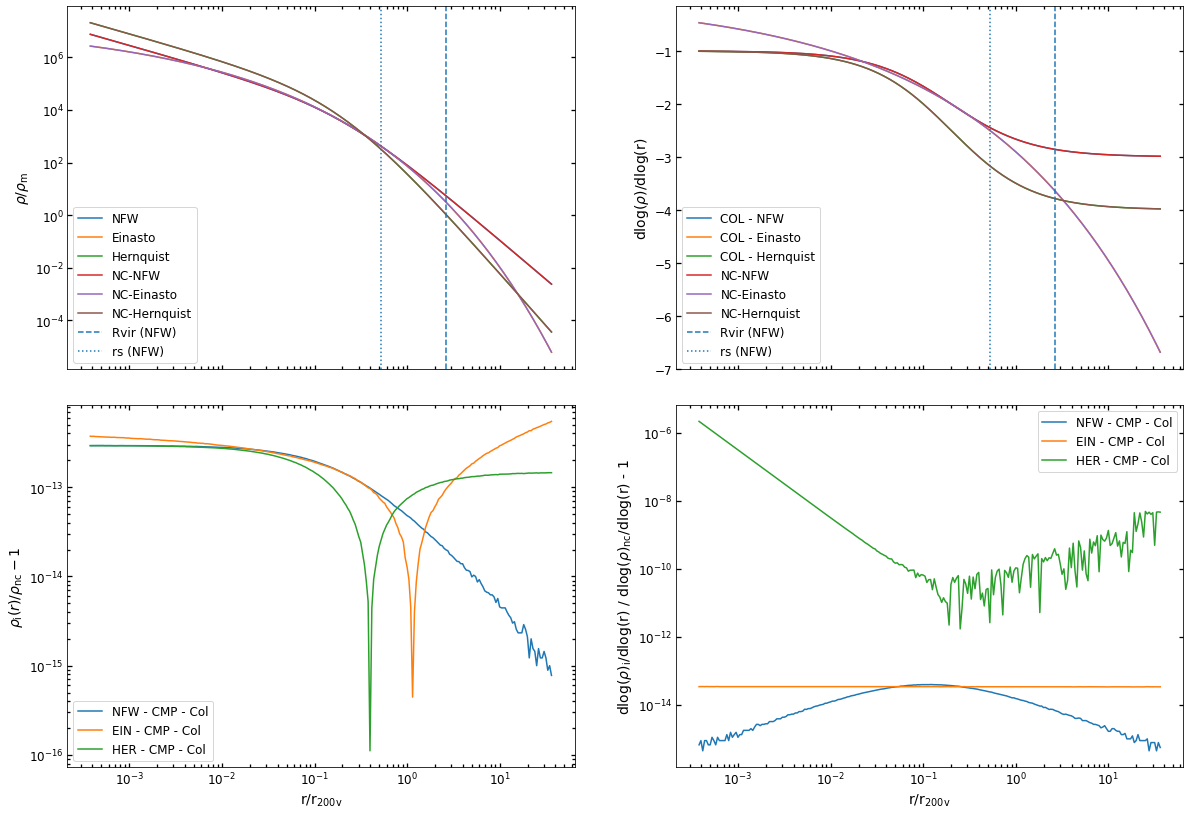

In [21]:
plt.figure()
fig, axs = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(20,14))

axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[1,0].set_xlabel(r'${\mathrm{r/r_{200v}}}$')
axs[0,0].set_ylabel(r'$\rho / \rho_{\mathrm{m}}$')
axs[0,0].plot(r/Rvir_nfw, col_rho_nfw / rho_m, '-', lw = 1.5, label = 'NFW');
axs[0,0].plot(r/Rvir_nfw, col_rho_ein / rho_m, '-', lw = 1.5, label = 'Einasto');
axs[0,0].plot(r/Rvir_nfw, col_rho_her / rho_m, '-', lw = 1.5, label = 'Hernquist');

axs[0,0].plot(r/Rvir_nfw, nc_rho_nfw / rho_m, '-', lw = 1.5, label = 'NC-NFW');
axs[0,0].plot(r/Rvir_nfw, nc_rho_ein / rho_m, '-', lw = 1.5, label = 'NC-Einasto');
axs[0,0].plot(r/Rvir_nfw, nc_rho_her / rho_m, '-', lw = 1.5, label = 'NC-Hernquist');
axs[0,0].axvline(Rvir_nfw, ls = '--', label = 'Rvir (NFW)');
axs[0,0].axvline(rs, ls = ':', label = 'rs (NFW)');
axs[0,0].legend(loc='best')
axs[0,0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0,0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1,0].set_yscale('log')
axs[1,0].set_ylabel(r'$\rho_{\mathrm{i}}(r) / \rho_{\mathrm{nc}} - 1$')
axs[1,0].plot(r/Rvir_nfw, np.abs(col_rho_nfw/nc_rho_nfw - 1.), '-', lw = 1.5, label = "NFW - CMP - Col");
axs[1,0].plot(r/Rvir_nfw, np.abs(col_rho_ein/nc_rho_ein - 1.), '-', lw = 1.5, label = "EIN - CMP - Col");
axs[1,0].plot(r/Rvir_nfw, np.abs(col_rho_her/nc_rho_her - 1.), '-', lw = 1.5, label = "HER - CMP - Col");
axs[1,0].legend(loc='best');
axs[1,0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1,0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

##################################################################################################################
axs[0,1].set_xscale('log')
axs[1,1].set_xlabel(r'${\mathrm{r/r_{200v}}}$')
axs[0,1].set_ylabel(r'dlog($\rho$)/dlog(r)')

axs[0,1].plot(r/Rvir_nfw, col_dlog_nfw , '-', lw=1.5, label = 'COL - NFW');
axs[0,1].plot(r/Rvir_nfw, col_dlog_ein, '-', lw=1.5, label = 'COL - Einasto');
axs[0,1].plot(r/Rvir_nfw, col_dlog_her, '-', lw=1.5, label = 'COL - Hernquist');


axs[0,1].plot(r/Rvir_nfw, nc_dlog_nfw, '-', lw=1.5, label = 'NC-NFW');
axs[0,1].plot(r/Rvir_nfw, nc_dlog_ein, '-', lw=1.5, label = 'NC-Einasto');
axs[0,1].plot(r/Rvir_nfw, nc_dlog_her, '-', lw=1.5, label = 'NC-Hernquist');
axs[0,1].axvline(Rvir_nfw, ls = '--', label = 'Rvir (NFW)');
axs[0,1].axvline(rs, ls = ':', label = 'rs (NFW)');
axs[0,1].legend(loc='best')
axs[0,1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0,1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1,1].set_yscale('log')
axs[1,1].set_ylabel(r'dlog$(\rho)_{\mathrm{i}}$/dlog(r) / dlog$(\rho)_{\mathrm{nc}}$/dlog(r) - 1')
axs[1,1].plot(r/Rvir_nfw, np.abs(col_dlog_nfw/nc_dlog_nfw - 1.), '-', lw=1.5, label = "NFW - CMP - Col");
axs[1,1].plot(r/Rvir_nfw, np.abs(col_dlog_ein/nc_dlog_ein - 1.), '-', lw=1.5, label = "EIN - CMP - Col");
axs[1,1].plot(r/Rvir_nfw, np.abs(col_dlog_her/nc_dlog_her - 1.), '-', lw=1.5, label = "HER - CMP - Col");
axs[1,1].legend(loc='best')
axs[1,1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1,1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

#plt.show()
plt.savefig ("inner_loginner_profiles.pdf", bbox_inches='tight')

**Comparing NFW, Einasto and Hernquist logarithmic derivative of the outer profiles $dlog(\rho)/dlog(r)$**

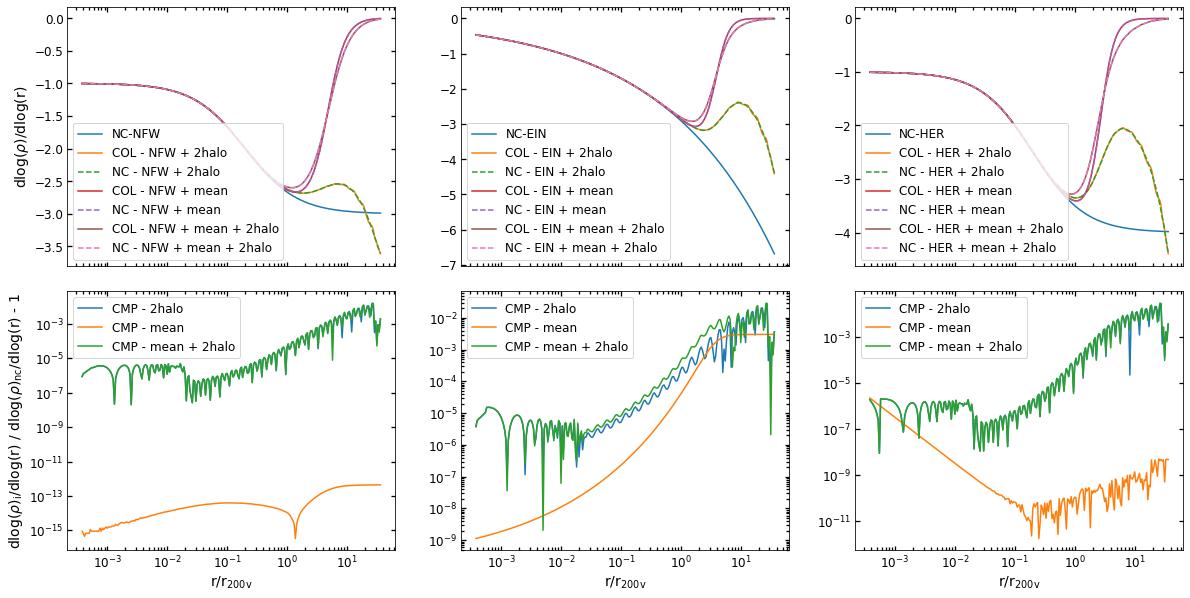

In [22]:
fig, axs = plt.subplots(2, 3, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(20,10))

axs[0,0].set_xscale('log')
axs[0,0].set_ylabel(r'dlog($\rho$)/dlog(r)')
axs[0,0].plot(r/Rvir_nfw, nc_dlog_nfw, '-', lw=1.5, label = 'NC-NFW');
axs[0,0].plot(r/Rvir_nfw, col_dlog_2h_nfw, '-',lw = 1.5, label = 'COL - NFW + 2halo')
axs[0,0].plot(r/Rvir_nfw, nc_dlog_2h_nfw, '--', lw = 1.5, label = 'NC - NFW + 2halo')
axs[0,0].plot(r/Rvir_nfw, col_dlog_mean_nfw, '-', lw = 1.5, label = 'COL - NFW + mean' )
axs[0,0].plot(r/Rvir_nfw, nc_dlog_mean_nfw, '--', lw = 1.5, label = 'NC - NFW + mean' )
axs[0,0].plot(r/Rvir_nfw, col_dlog_2h_mean_nfw, '-', lw = 1.5, label = 'COL - NFW + mean + 2halo' )
axs[0,0].plot(r/Rvir_nfw, nc_dlog_2h_mean_nfw, '--', lw = 1.5, label = 'NC - NFW + mean + 2halo' )

axs[0,0].legend(loc='best')
axs[0,0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0,0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[0,1].set_xscale('log')
#axs[0,1].set_ylabel(r'$\rho / \rho_{\mathrm{m}}$')
axs[0,1].plot(r/Rvir_nfw, nc_dlog_ein, '-', lw=1.5, label = 'NC-EIN');
axs[0,1].plot(r/Rvir_nfw, col_dlog_2h_ein, '-',lw = 1.5, label = 'COL - EIN + 2halo')
axs[0,1].plot(r/Rvir_nfw, nc_dlog_2h_ein, '--', lw = 1.5, label = 'NC - EIN + 2halo')
axs[0,1].plot(r/Rvir_nfw, col_dlog_mean_ein, '-', lw = 1.5, label = 'COL - EIN + mean' )
axs[0,1].plot(r/Rvir_nfw, nc_dlog_mean_ein, '--', lw = 1.5, label = 'NC - EIN + mean' )
axs[0,1].plot(r/Rvir_nfw, col_dlog_2h_mean_ein, '-', lw = 1.5, label = 'COL - EIN + mean + 2halo' )
axs[0,1].plot(r/Rvir_nfw, nc_dlog_2h_mean_ein, '--', lw = 1.5, label = 'NC - EIN + mean + 2halo' )
axs[0,1].legend(loc='best')
axs[0,1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0,1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[0,2].set_xscale('log')
#axs[0,2].set_ylabel(r'$\rho / \rho_{\mathrm{m}}$')
axs[0,2].plot(r/Rvir_nfw, nc_dlog_her, '-', lw=1.5, label = 'NC-HER');
axs[0,2].plot(r/Rvir_nfw, col_dlog_2h_her, '-',lw = 1.5, label = 'COL - HER + 2halo')
axs[0,2].plot(r/Rvir_nfw, nc_dlog_2h_her, '--', lw = 1.5, label = 'NC - HER + 2halo')
axs[0,2].plot(r/Rvir_nfw, col_dlog_mean_her, '-', lw = 1.5, label = 'COL - HER + mean' )
axs[0,2].plot(r/Rvir_nfw, nc_dlog_mean_her, '--', lw = 1.5, label = 'NC - HER + mean' )
axs[0,2].plot(r/Rvir_nfw, col_dlog_2h_mean_her, '-', lw = 1.5, label = 'COL - HER + mean + 2halo' )
axs[0,2].plot(r/Rvir_nfw, nc_dlog_2h_mean_her, '--', lw = 1.5, label = 'NC - HER + mean + 2halo' )
axs[0,2].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0,2].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0,2].legend(loc='best')
###################################################################################################################

axs[1,0].set_xlabel(r'${\mathrm{r/r_{200v}}}$')
axs[1,0].set_ylabel(r'dlog$(\rho)_{\mathrm{i}}$/dlog(r) / dlog$(\rho)_{\mathrm{nc}}$/dlog(r) - 1')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].plot(r/Rvir_nfw, np.abs(col_dlog_2h_nfw/nc_dlog_2h_nfw - 1.0), '-', lw = 1.5, label = 'CMP - 2halo');
axs[1,0].plot(r/Rvir_nfw, np.abs(col_dlog_mean_nfw/nc_dlog_mean_nfw - 1.0), '-', lw = 1.5, label = 'CMP - mean');
axs[1,0].plot(r/Rvir_nfw, np.abs(col_dlog_2h_mean_nfw/nc_dlog_2h_mean_nfw- 1.0), '-', lw = 1.5, label = 'CMP - mean + 2halo');
axs[1,0].legend(loc='best')
axs[1,0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1,0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1,1].set_xlabel(r'${\mathrm{r/r_{200v}}}$')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].plot(r/Rvir_nfw, np.abs(col_dlog_2h_ein/nc_dlog_2h_ein - 1.0), '-', lw = 1.5, label = 'CMP - 2halo');
axs[1,1].plot(r/Rvir_nfw, np.abs(col_dlog_mean_ein/nc_dlog_mean_ein - 1.0), '-', lw = 1.5, label = 'CMP - mean');
axs[1,1].plot(r/Rvir_nfw, np.abs(col_dlog_2h_mean_ein/nc_dlog_2h_mean_ein - 1.0), '-', lw = 1.5, label = 'CMP - mean + 2halo');
axs[1,1].legend(loc='best')
axs[1,1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1,1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1,2].set_xlabel(r'${\mathrm{r/r_{200v}}}$')
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].plot(r/Rvir_nfw, np.abs(col_dlog_2h_her/nc_dlog_2h_her - 1.0), '-', lw = 1.5, label = 'CMP - 2halo');
axs[1,2].plot(r/Rvir_nfw, np.abs(col_dlog_mean_her/nc_dlog_mean_her - 1.0), '-', lw = 1.5, label = 'CMP - mean');
axs[1,2].plot(r/Rvir_nfw, np.abs(col_dlog_2h_mean_her/nc_dlog_2h_mean_her - 1.0), '-', lw = 1.5, label = 'CMP - mean + 2halo');
axs[1,2].legend(loc='best')
axs[1,2].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1,2].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

plt.savefig ("dlog_outer_profiles.pdf", dpi=300, bbox_inches='tight')

**Comparing NFW, Einasto and Hernquist outer profiles $\rho(r) /\rho_m$**

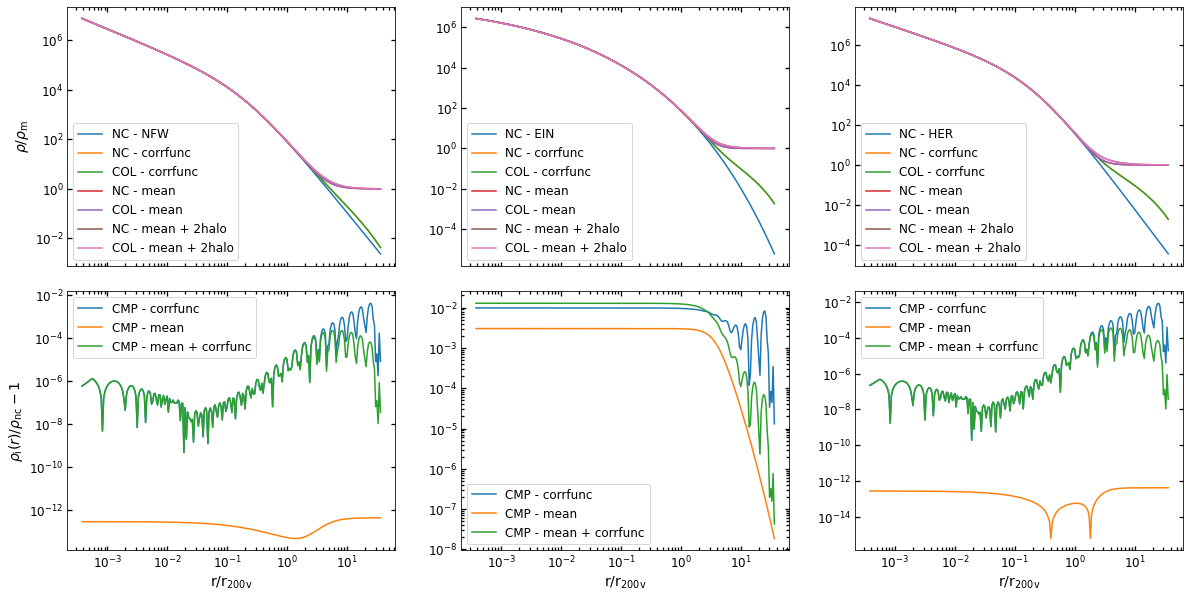

In [23]:
fig, axs = plt.subplots(2, 3, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(20,10))

axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel(r'$\rho / \rho_{\mathrm{m}}$')
axs[0,0].plot(r/Rvir_nfw, nc_rho_nfw / rho_m, '-', lw = 1.5, label = 'NC - NFW' );
axs[0,0].plot(r/Rvir_nfw, nc_outer_NFW / rho_m, '-', lw = 1.5, label = 'NC - corrfunc' );
axs[0,0].plot(r/Rvir_nfw, rho_cf_NFW / rho_m, '-', lw = 1.5, label = 'COL - corrfunc');
axs[0,0].plot(r/Rvir_nfw, nc_mean_NFW / rho_m, '-', lw = 1.5, label = 'NC - mean' );
axs[0,0].plot(r/Rvir_nfw, rho_outer_NFW / rho_m, '-', lw = 1.5, label = 'COL - mean');
axs[0,0].plot(r/Rvir_nfw, nc_2h_mean_NFW / rho_m, '-', lw = 1.5, label = 'NC - mean + 2halo' );
axs[0,0].plot(r/Rvir_nfw, rho_mean_cf_NFW / rho_m, '-', lw = 1.5, label = 'COL - mean + 2halo');
axs[0,0].legend(loc='best')
axs[0,0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0,0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].plot(r/Rvir_nfw, nc_rho_ein / rho_m, '-', lw = 1.5, label = 'NC - EIN' );
axs[0,1].plot(r/Rvir_nfw, nc_outer_EIN / rho_m, '-', lw = 1.5, label = 'NC - corrfunc' );
axs[0,1].plot(r/Rvir_nfw, rho_cf_EIN / rho_m, '-', lw = 1.5, label = 'COL - corrfunc');
axs[0,1].plot(r/Rvir_nfw, nc_mean_EIN / rho_m, '-', lw = 1.5, label = 'NC - mean' );
axs[0,1].plot(r/Rvir_nfw, rho_outer_EIN / rho_m, '-', lw = 1.5, label = 'COL - mean');
axs[0,1].plot(r/Rvir_nfw, nc_2h_mean_EIN / rho_m, '-', lw = 1.5, label = 'NC - mean + 2halo' );
axs[0,1].plot(r/Rvir_nfw, rho_mean_cf_EIN / rho_m, '-', lw = 1.5, label = 'COL - mean + 2halo');
axs[0,1].legend(loc='best')
axs[0,1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0,1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].plot(r/Rvir_nfw, nc_rho_her / rho_m, '-', lw = 1.5, label = 'NC - HER' );
axs[0,2].plot(r/Rvir_nfw, nc_outer_HER / rho_m, '-', lw = 1.5, label = 'NC - corrfunc' );
axs[0,2].plot(r/Rvir_nfw, rho_cf_HER / rho_m, '-', lw = 1.5, label = 'COL - corrfunc');
axs[0,2].plot(r/Rvir_nfw, nc_mean_HER / rho_m, '-', lw = 1.5, label = 'NC - mean' );
axs[0,2].plot(r/Rvir_nfw, rho_outer_HER / rho_m, '-', lw = 1.5, label = 'COL - mean');
axs[0,2].plot(r/Rvir_nfw, nc_2h_mean_HER / rho_m, '-', lw = 1.5, label = 'NC - mean + 2halo' );
axs[0,2].plot(r/Rvir_nfw, rho_mean_cf_HER / rho_m, '-', lw = 1.5, label = 'COL - mean + 2halo');
axs[0,2].legend(loc='best')
axs[0,2].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0,2].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

###################################################################################################################

axs[1,0].set_xlabel(r'${\mathrm{r/r_{200v}}}$')
axs[1,0].set_ylabel(r'$\rho_{\mathrm{i}}(r) / \rho_{\mathrm{nc}} - 1$')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].plot(r/Rvir_nfw, np.abs(rho_cf_NFW/nc_outer_NFW - 1.0), '-', lw = 1.5, label = 'CMP - corrfunc');
axs[1,0].plot(r/Rvir_nfw, np.abs(rho_outer_NFW/nc_mean_NFW - 1.0), '-', lw = 1.5, label = 'CMP - mean');
axs[1,0].plot(r/Rvir_nfw, np.abs(rho_mean_cf_NFW/nc_2h_mean_NFW - 1.0), '-', lw = 1.5, label = 'CMP - mean + corrfunc');
axs[1,0].legend(loc='best')
axs[1,0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1,0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1,1].set_xlabel(r'${\mathrm{r/r_{200v}}}$')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].plot(r/Rvir_nfw, np.abs(rho_cf_EIN/nc_outer_EIN - 1.0), '-', lw = 1.5, label = 'CMP - corrfunc');
axs[1,1].plot(r/Rvir_nfw, np.abs(rho_outer_EIN/nc_mean_EIN - 1.0), '-', lw = 1.5, label = 'CMP - mean');
axs[1,1].plot(r/Rvir_nfw, np.abs(rho_mean_cf_EIN/nc_2h_mean_EIN - 1.0), '-', lw = 1.5, label = 'CMP - mean + corrfunc');
axs[1,1].legend(loc='best')
axs[1,1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1,1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1,2].set_xlabel(r'${\mathrm{r/r_{200v}}}$')
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].plot(r/Rvir_nfw, np.abs(rho_cf_HER/nc_outer_HER - 1.0), '-', lw = 1.5, label = 'CMP - corrfunc');
axs[1,2].plot(r/Rvir_nfw, np.abs(rho_outer_HER/nc_mean_HER - 1.0), '-', lw = 1.5, label = 'CMP - mean');
axs[1,2].plot(r/Rvir_nfw, np.abs(rho_mean_cf_HER/nc_2h_mean_HER - 1.0), '-', lw = 1.5, label = 'CMP - mean + corrfunc');
axs[1,2].legend(loc='best')
axs[1,2].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1,2].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

plt.savefig ("rho_outer_profiles.pdf", dpi=300, bbox_inches='tight')

**Comparing NFW, Einasto and Hernquist surface mass density $\Sigma (R)$**

In the last part of this notebook we will review the lens models for the dark matter halo density profiles presented here. At NumCosmo, the functions for calculating these models are found in the module [NcWLSurfaceMassDensity](https://numcosmo.github.io/manual/NcWLSurfaceMassDensity.html).

<Figure size 432x288 with 0 Axes>

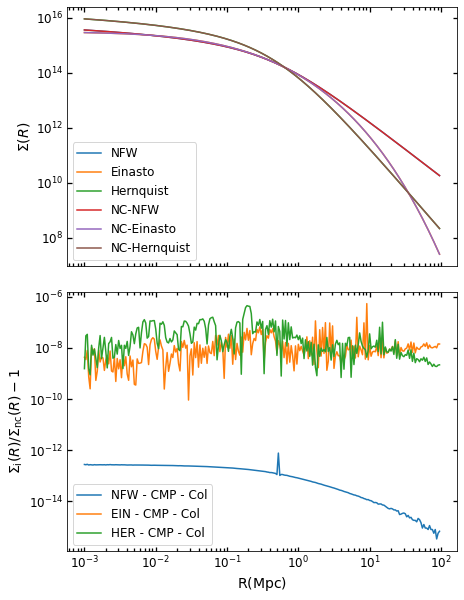

In [24]:
# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)
col_Sigma_ein = col_ein.surfaceDensity (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)
col_Sigma_her = col_her.surfaceDensity (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
nc_Sigma_nfw  = smd.sigma_array (nc_nfw, cosmo, r, 1.0, 1.0, z)
nc_Sigma_ein  = smd.sigma_array (nc_ein, cosmo, r, 1.0, 1.0, z)
nc_Sigma_her  = smd.sigma_array (nc_her, cosmo, r, 1.0, 1.0, z)

plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xlabel(r'${\mathrm{R(Mpc)}}$')
axs[0].set_ylabel('$\Sigma(R)$')
axs[0].plot(r, col_Sigma_nfw , '-', lw=1.5, label = 'NFW');
axs[0].plot(r, col_Sigma_ein, '-', lw=1.5, label = 'Einasto');
axs[0].plot(r, col_Sigma_her, '-', lw=1.5, label = 'Hernquist');

axs[0].plot(r, nc_Sigma_nfw, '-', lw=1.5, label = 'NC-NFW');
axs[0].plot(r, nc_Sigma_ein, '-', lw=1.5, label = 'NC-Einasto');
axs[0].plot(r, nc_Sigma_her, '-', lw=1.5, label = 'NC-Hernquist');
axs[0].legend(loc='best')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\Sigma_{\mathrm{i}} (R) / \Sigma_{\mathrm{nc}} (R) - 1$')
axs[1].plot(r, np.abs(col_Sigma_nfw/nc_Sigma_nfw - 1.), '-', lw=1.5, label = "NFW - CMP - Col");
axs[1].plot(r, np.abs(col_Sigma_ein/nc_Sigma_ein - 1.), '-', lw=1.5, label = "EIN - CMP - Col");
axs[1].plot(r, np.abs(col_Sigma_her/nc_Sigma_her - 1.), '-', lw=1.5, label = "HER - CMP - Col");
axs[1].legend(loc='lower left')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

plt.savefig ("sigma_profiles.pdf", bbox_inches='tight')

**Comparing NFW, Einasto and Hernquist excess $\Delta\Sigma (R) = \overline\Sigma (<R) - \Sigma(R)$**

<Figure size 432x288 with 0 Axes>

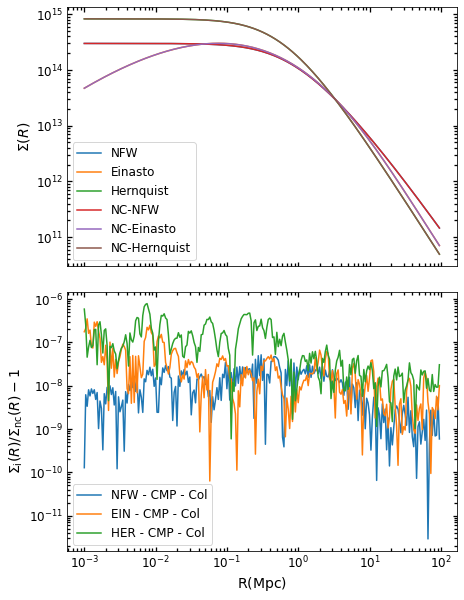

In [25]:
# Colossus
col_DeltaSigma_nfw  = col_nfw.deltaSigma (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)
col_DeltaSigma_ein  = col_ein.deltaSigma (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)
col_DeltaSigma_her  = col_her.deltaSigma (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
nc_DeltaSigma_nfw  = np.array (smd.sigma_excess_array (nc_nfw, cosmo, r, 1.0, 1.0, z))
nc_DeltaSigma_ein  = np.array (smd.sigma_excess_array (nc_ein, cosmo, r, 1.0, 1.0, z))
nc_DeltaSigma_her  = np.array (smd.sigma_excess_array (nc_her, cosmo, r, 1.0, 1.0, z))

plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xlabel(r'${\mathrm{R(Mpc)}}$')
axs[0].set_ylabel('$\Sigma(R)$')
axs[0].plot(r, col_DeltaSigma_nfw , '-', lw=1.5, label = 'NFW');
axs[0].plot(r, col_DeltaSigma_ein, '-', lw=1.5, label = 'Einasto');
axs[0].plot(r, col_DeltaSigma_her, '-', lw=1.5, label = 'Hernquist');

axs[0].plot(r, nc_DeltaSigma_nfw, '-', lw=1.5, label = 'NC-NFW');
axs[0].plot(r, nc_DeltaSigma_ein, '-', lw=1.5, label = 'NC-Einasto');
axs[0].plot(r, nc_DeltaSigma_her, '-', lw=1.5, label = 'NC-Hernquist');
axs[0].legend(loc='best')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)

axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\Sigma_{\mathrm{i}} (R) / \Sigma_{\mathrm{nc}} (R) - 1$')
axs[1].plot(r, np.abs(col_DeltaSigma_nfw/nc_DeltaSigma_nfw - 1.), '-', lw=1.5, label = "NFW - CMP - Col");
axs[1].plot(r, np.abs(col_DeltaSigma_ein/nc_DeltaSigma_ein - 1.), '-', lw=1.5, label = "EIN - CMP - Col");
axs[1].plot(r, np.abs(col_DeltaSigma_her/nc_DeltaSigma_her - 1.), '-', lw=1.5, label = "HER - CMP - Col");
axs[1].legend(loc='lower left')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor', direction='in', right=True, top=True,length=3.0, width=1.3)

plt.savefig ("delta_sigma_profiles.pdf", bbox_inches='tight')